In [1]:
using Turing
using StatsPlots
using Optim

In [2]:
PRINT_PROGRESS = true
include("read_data.jl")
include("utils.jl")
include("lecture/plot_utils.jl");

### Dataset: World-Wide Monthly Air Passengers

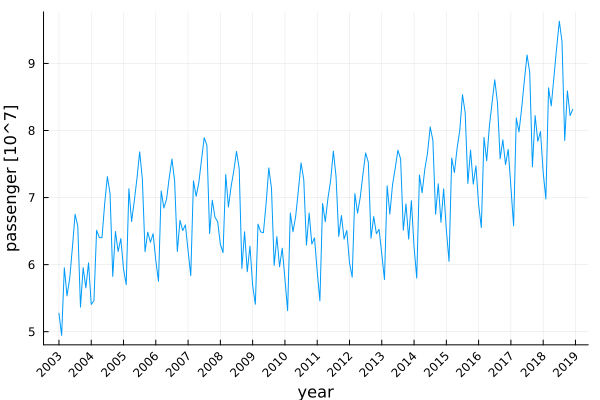

In [3]:
base_plot(air_passengers_2013_2018)

In [4]:
x = air_passengers_2013_2018[!,"Date"]
y = air_passengers_2013_2018[!,"Total"];

In [5]:
function seasonality_component(t::Float64, N_frequencies::Int, beta::Vector{<:Real})
    s = 0
    for n in 1:N_frequencies
        s += beta[2*n-1] * sin(2*pi*n*t)
        s += beta[2*n] * cos(2*pi*n*t)
    end
    return s
end

@model function prophet(x::Vector{Float64}, y::Vector{Float64}, N_frequencies::Int)
    slope ~ Normal(0,3)
    intercept ~ Normal(6,3)
    error ~ InverseGamma(2,3)
    n_changepoints = Int(ceil(length(y) / 12)) # changepoint at each year
    tau ~ InverseGamma(1,1)
    adjustments ~ filldist(Laplace(0,tau+1e-5), n_changepoints)
    beta ~ filldist(Normal(0,1.), 2*N_frequencies)

    k = slope
    m = intercept
    j = 1
    for i in eachindex(y)
        t = (x[i] - x[1])
        if i % 12 == 1
            k += adjustments[j]
            m -= t * adjustments[j]
            j += 1
        end
        s = seasonality_component(t, N_frequencies, beta)

        y[i] ~ Normal(k * t + m + s, error+1e-5)
    end
end

prophet (generic function with 2 methods)

In [6]:
N_frequencies = 3
changepoints = x[(1:length(x)) .% 12 .== 1] .- x[1]

Turing.Random.seed!(1)
map_estimate = optimize(prophet(x, y, N_frequencies), MAP(), Optim.Options(iterations=10000))

ModeResult with maximized lp of -23.59
[0.4577668853959833, 5.676798414159017, 0.26486973435303784, 0.15564037214657933, -1.8024725766680047e-16, -3.524588295884899e-17, -0.33308075971101825, -1.3193756999074557e-10, -0.013055172774100565, -0.599594466878374  …  3.00675322887742e-6, 3.2354536360592883e-18, 0.0027787046763455446, 6.748800756489422e-16, 0.12903737468239745, -0.6323295364796718, -0.11315127980651665, 0.07650192846864177, -0.15896492058501327, -0.29719464597431666]

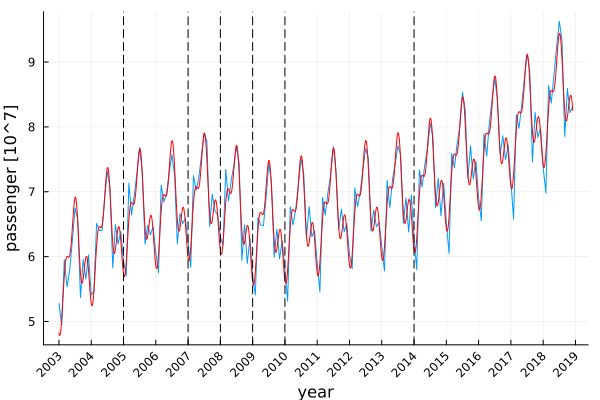

In [7]:
map_vector = map_estimate.values.array
n_changepoints = length(y) ÷ 12

plot_prophet_model(air_passengers_2013_2018, map_vector, N_frequencies, n_changepoints)

In [8]:
Turing.Random.seed!(0)
res_prophet = sample(prophet(x, y, N_frequencies), NUTS(), 1000, progress=PRINT_PROGRESS, init_params=map_estimate.values.array);

┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:49


### Using the resulting posterior

Let $X$ be the data and $T$ some quantity of interest.

We can find the *posterior predictive distribution* over $T$ by "averaging over the posterior":

$p (T | X) = \int p(T | \theta, X) p(\theta | X) d\theta$

For instance, $T$ = how large is the difference between January and August passengers?

"Averaging over the posterior" is simply looking at the histogram.

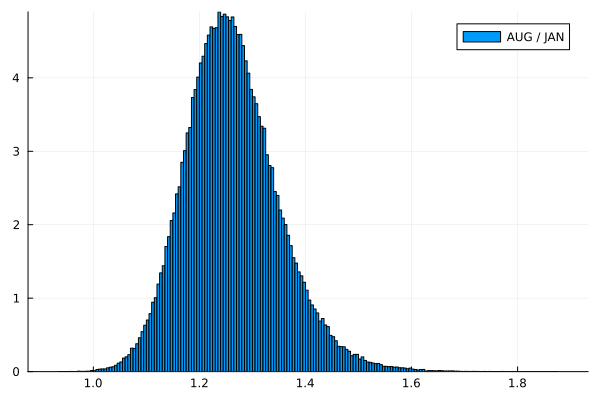

In [12]:
T = Float64[]

n_years = length(y) ÷ 12
n_samples_per_trace = 10

# iterate over posterior
for i in 1:length(res_prophet)
    trace = reshape(res_prophet[i].value.data, :)

    slope, intercept, error, tau,  adjustments = trace[1:4]..., trace[5:(5+n_changepoints-1)]
    beta = trace[5+n_changepoints : end]
        
    # produce samples for T | θ, X
    for year in 0:(n_years-1)
        jan_mean = prophet_model_f(x[year * 12 + 1] - x[1], slope, intercept, changepoints, adjustments, N_frequencies, beta)
        aug_mean = prophet_model_f(x[year * 12 + 8] - x[1], slope, intercept, changepoints, adjustments, N_frequencies, beta)
        
        for _ in 1:n_samples_per_trace
            jan = rand(Normal(jan_mean, error))
            aug = rand(Normal(aug_mean, error))
            push!(T, aug / jan)
        end
    end
end
histogram(T, normalize=true, label="AUG / JAN")

In [13]:
mean(T)

1.2622266753042009

## Forecasting

In [14]:
function prophet_forecast(x::Vector{Float64}, y::Vector{Float64},
    m::Float64, k::Float64, error::Float64, N_frequencies::Int, beta::Vector{Float64}, adjustments::Vector{Float64},
    forecast::Int)

    tau = mean(abs, adjustments)

    n_future_changepoints = ((length(y) + forecast) ÷ 12) - (length(y) ÷ 12)
    future_adjustments = rand(filldist(Laplace(0,tau), n_future_changepoints))

    y_pred = zeros(forecast)
    Δ = x[2] - x[1]
    x_future = x[end]
    i = length(y)+1
    j = 1
    while i <= length(y) + forecast
        x_future += Δ
        t = (x_future - x[1])

        if i % 12 == 1
            k += future_adjustments[j]
            m -= t * future_adjustments[j]
            j += 1
        end

        s = seasonality_component(t, N_frequencies, beta)
        y_pred[i-length(y)] = rand(Normal(k * t + m + s, error))
        i += 1
    end

    return y_pred
end

prophet_forecast (generic function with 1 method)

In [15]:
function sample_forecast(res, changepoints, forecast, n_samples_per_trace)
    n_changepoints = length(changepoints)
    y_pred = zeros(n_samples_per_trace * length(res), forecast)

    j = 0
    for i in 1:length(res)
        trace = reshape(res[i].value.data, :)

        slope, intercept, error, tau,  adjustments = trace[1:4]..., trace[5:(5+n_changepoints-1)]
        beta = trace[5+n_changepoints : end]

        for _ in 1:n_samples_per_trace
            j += 1
            k = slope + sum(adjustments)
            m = intercept - adjustments'changepoints
            y_pred[j,:] = prophet_forecast(x,y,m,k,error,N_frequencies,beta,adjustments,forecast)
        end
    end
    return y_pred
end

sample_forecast (generic function with 1 method)

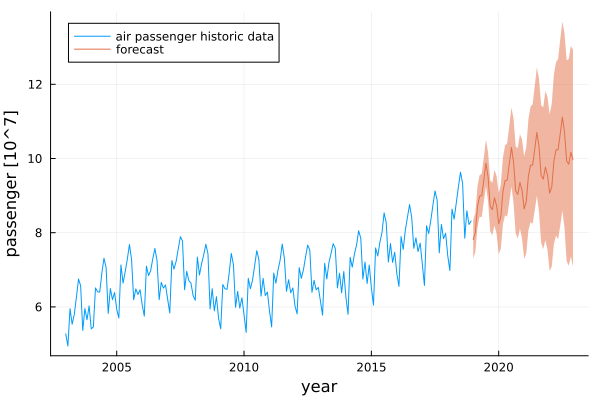

In [16]:
n_year_forecast = 4
forecast = n_year_forecast * 12
x_forecast = collect(maximum(x) .+ (1:forecast)./12)

y_pred = sample_forecast(res_prophet, changepoints, forecast, 10)
plot_forecast(x, y, x_forecast, y_pred)

### Bonus

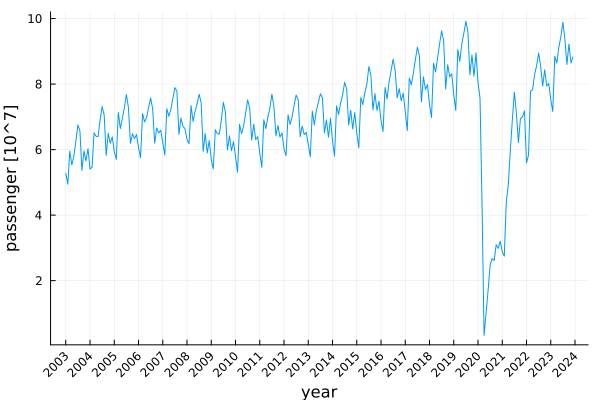

In [17]:
base_plot(air_passengers_2013_2023)

In [18]:
N_frequencies = 3
x = air_passengers_2013_2023[!,"Date"]
y = air_passengers_2013_2023[!,"Total"]
changepoints = x[(1:length(x)) .% 12 .== 1] .- x[1];

In [19]:
Turing.Random.seed!(0)
map_estimate = optimize(prophet(x, y, N_frequencies), MAP(), Optim.Options(iterations=10000))

Turing.Random.seed!(0)
res_prophet_2023 = sample(prophet(x, y, N_frequencies), NUTS(), 1000, progress=PRINT_PROGRESS, init_params=map_estimate.values.array);

┌ Info: Found initial step size
└   ϵ = 0.00625
Sampling: 100%|█████████████████████████████████████████| Time: 0:02:26


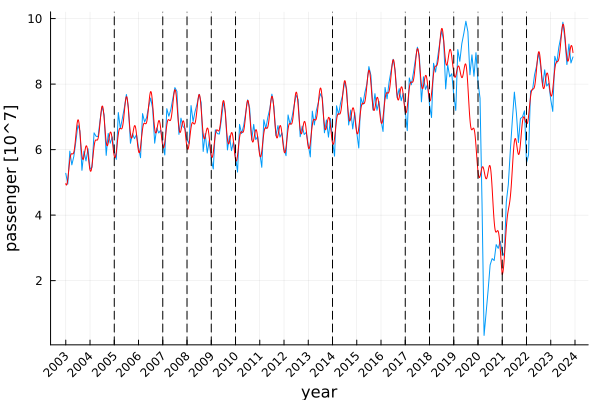

In [20]:
map_vector = map_estimate.values.array
n_changepoints = length(y) ÷ 12

plot_prophet_model(air_passengers_2013_2023, map_vector, N_frequencies, n_changepoints)

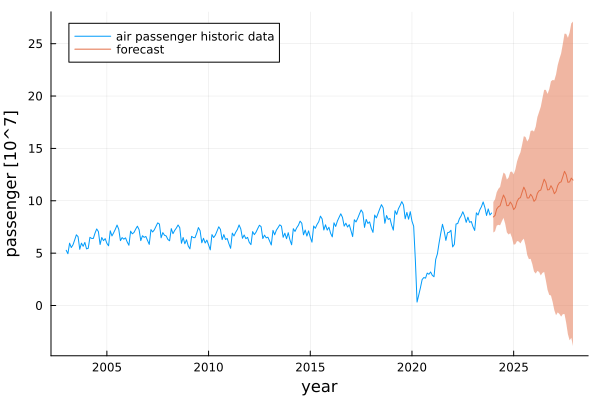

In [21]:
n_year_forecast = 4
forecast = n_year_forecast * 12
x_forecast = collect(maximum(x) .+ (1:forecast)./12)

y_pred = sample_forecast(res_prophet_2023, changepoints, forecast, 10)
plot_forecast(x, y, x_forecast, y_pred)

In [ ]:
@model function prophet_covid(x::Vector{Float64}, y::Vector{Float64}, N_frequencies::Int)
    slope ~ Normal(0,3)
    intercept ~ Normal(6,3)
    error ~ InverseGamma(2,3)
    n_changepoints = Int(ceil(length(y) / 12)) # changepoint at each year
    tau ~ InverseGamma(1,1)
    adjustments ~ filldist(Laplace(0,tau+1e-5), n_changepoints)
    beta ~ filldist(Normal(0,1.), 2*N_frequencies)

    # UPGRADE: latent shock variables for the years 2021 to 2023
    shock_2020 ~ Normal(-5,1)
    shock_2021 ~ Normal(-3,1)
    shock_2022 ~ Normal(-1,1)

    k = slope
    m = intercept
    j = 1
    for i in eachindex(y)
        t = (x[i] - x[1])
        if i % 12 == 1
            k += adjustments[j]
            m -= t * adjustments[j]
            j += 1
        end
        s = seasonality_component(t, N_frequencies, beta)


        # UPGRADE: extra "intercept" variables for the years 2021 to 2023
        if 2020 ≤ x[i] && x[i] < 2021
            d = shock_2020
        elseif 2021 ≤ x[i] && x[i] < 2022
            d = shock_2021
        elseif 2022 ≤ x[i] && x[i] < 2023
            d = shock_2022
        else
            d = 0
        end

        y[i] ~ Normal(k * t + m + s + d, error+1e-5)
    end
end

In [ ]:
N_frequencies = 3
x = air_passengers_2013_2023[!,"Date"]
y = air_passengers_2013_2023[!,"Total"]
changepoints = x[(1:length(x)) .% 12 .== 1] .- x[1]

Turing.Random.seed!(0)
map_estimate = optimize(prophet_covid(x, y, N_frequencies), MAP(), Optim.Options(iterations=10000))

Turing.Random.seed!(0)
res_prophet_covid = sample(prophet_covid(x, y, N_frequencies), NUTS(), 1000, progress=PRINT_PROGRESS, init_params=map_estimate.values.array);

In [ ]:
map_vector = map_estimate.values.array
plot_prophet_covid_model(air_passengers_2013_2023, map_vector, N_frequencies, n_changepoints)

In [ ]:
n_year_forecast = 4
forecast = n_year_forecast * 12
x_forecast = collect(maximum(x) .+ (1:forecast)./12)

y_pred = sample_forecast(res_prophet_covid, changepoints, forecast, 10)
plot_forecast(x, y, x_forecast, y_pred)